based on pointsim notebook

In [13]:
import numpy as np
import pandas as pd
from pcse.db import NASAPowerWeatherDataProvider
from pcse.util import reference_ET
import datetime
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm
import yaml
import io

sys.path.append("../../src/")
from sarra_py import *

In [26]:
#databse bruelle
from datetime import datetime as dt
observations = pd.read_csv("../../data/observations/2006-2010_database_bvlac_bruelle.csv",sep=";")
observations = observations[observations["village"]=="Ambohimiarina"].reset_index(drop=True)
observations["sowdate"] = observations.apply(lambda x: dt.strptime(x["sowdate"],"%Y-%m-%d"), axis=1)
# observations
observations.groupby(["village","cropseason"]).mean()

area       manure       urea        npk  \
village       cropseason                                                 
Ambohimiarina Y06_07      15.435019  2595.589494  53.971595  64.161868   
              Y07_08      13.286343  1609.448380  21.321759  44.712037   
              Y08_09       0.159906   227.877358   1.395519   1.522406   
              Y09_10       0.148195     0.000000   0.000000   0.000000   

                           nitrogen     rainsow    rainflow    raincycle  \
village       cropseason                                                   
Ambohimiarina Y06_07      31.884739   61.885603  164.763035  1120.277043   
              Y07_08      14.726333  145.927778   56.892593   897.879630   
              Y08_09       0.809403   69.348113  159.716981   959.294340   
              Y09_10       0.000000   72.977919  141.464968   939.850531   

                          rainyear        yield  
village       cropseason                         
Ambohimiarina Y06_07        1288.7  2557.410895  
              Y07_08        1062.2  2642.822454  
              Y08_09        1331.4  2970.492689  
              Y09_10        1105.0  2778.202548

In [27]:
observations["DOY"] = observations.apply(lambda x: x["sowdate"].timetuple().tm_yday, axis=1)

In [28]:
observations.groupby(["village","cropseason"]).quantile(0.25)

/tmp/ipykernel_13584/3770020463.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  observations.groupby(["village","cropseason"]).quantile(0.25)


area             sowdate  manure  urea  npk  \
village       cropseason                                                
Ambohimiarina Y06_07       6.5 2006-12-01 00:00:00  1666.7   0.0  0.0   
              Y07_08       6.0 2007-12-21 00:00:00     0.0   0.0  0.0   
              Y08_09       0.1 2008-11-17 00:00:00     0.0   0.0  0.0   
              Y09_10       0.1 2009-12-01 12:00:00     0.0   0.0  0.0   

                          nitrogen  rainsow  rainflow  raincycle  rainyear  \
village       cropseason                                                     
Ambohimiarina Y06_07        13.156     28.4     137.6     1106.1    1288.7   
              Y07_08         0.000    127.0       8.6      825.0    1062.2   
              Y08_09         0.000     37.0      21.8      928.0    1331.4   
              Y09_10         0.000     33.4      13.8      896.2    1105.0   

                           yield     DOY  
village       cropseason                  
Ambohimiarina Y06_07      1950.0  333.00  
              Y07_08      2133.9   15.75  
              Y08_09      2250.0  321.00  
              Y09_10      2300.0  332.00

In [29]:
grid_width = 1
grid_height = 1
date_start = datetime.date(2006,4,1)
duration = 365*4

# parameter file names
file_paramVariete = "rice_variety.yaml"
file_paramITK = "rice_itk.yaml" # on va remplacer la date de semis
file_paramTypeSol = "rice_soil.yaml"

# data exported from SARRA-H
file_df_weather = "AgERA5_point_madagascar_Ambohimiarina_-18.83_47.13_2006_2010.csv"
file_df_rain = "TAMSAT_v3.1_point_madagascar_Ambohimiarina_18.83_47.13_2006_2010.csv"
file_df_ET0 = None
file_df_irrig = None

# simulated data from SARRA-H for comparison purposes
file_df_sim = "simu_AG3US20124.txt"

In [30]:
# Read YAML file
with open(os.path.join('../../data/params/variety/',file_paramVariete), 'r') as stream:
    paramVariete = yaml.safe_load(stream)
    

if paramVariete["feuilAeroBase"] == 0.1 :
    raise exception()

with open(os.path.join('../../data/params/itk/',file_paramITK), 'r') as stream:
    paramITK = yaml.safe_load(stream)

paramITK["DateSemis"] = datetime.datetime.strptime(paramITK["DateSemis"], "%Y-%m-%d").date()

with open(os.path.join('../../data/params/soil/',file_paramTypeSol), 'r') as stream:
    paramTypeSol = yaml.safe_load(stream)

if ~np.isnan(paramITK["NI"]):
    print("NI NON NULL") 
    paramVariete["txConversion"] = paramVariete["NIYo"] + paramVariete["NIp"] * (1-np.exp(-paramVariete["NIp"] * paramITK["NI"])) - (np.exp(-0.5*((paramITK["NI"] - paramVariete["LGauss"])/paramVariete["AGauss"])* (paramITK["NI"]- paramVariete["LGauss"])/paramVariete["AGauss"]))/(paramVariete["AGauss"]*2.506628274631)

In [31]:
# loading weather data and rain data exported from SARRA-H
# df weather
# df_weather = pd.read_csv(os.path.join('../../data/weather/',file_df_weather), sep="\t", decimal=",", skiprows=1)
df_weather = pd.read_csv(os.path.join('../../data/weather/',file_df_weather), sep=",", decimal=".")

# adaptation AgERA5
#df_weather["Jour"] = df_weather.apply(lambda x: datetime.datetime.strptime(x["Jour"], "%d/%m/%Y").date(), axis=1)
df_weather["Jour"] = df_weather.apply(lambda x: datetime.datetime.strptime(x["Jour_SARRA_H"], "%d/%m/%Y").date(), axis=1)
df_weather = df_weather[(df_weather["Jour"] >= date_start) & (df_weather["Jour"] <= date_start + datetime.timedelta(days=duration-1))].reset_index(drop=True)
df_weather["TMoy"] = ((df_weather["TMin"] + df_weather["TMax"]) / 2) 

# df rain
#df_rain = pd.read_csv(os.path.join('../../data/rain/',file_df_rain), sep="\t", decimal=",", skiprows=1)
df_rain = pd.read_csv(os.path.join('../../data/rain/',file_df_rain), sep=",", decimal=".")
# adaptation TAMSAT
# df_rain["Jour"] = df_rain.apply(lambda x: datetime.datetime.strptime(x["Jour"], "%d/%m/%Y").date(), axis=1)
df_rain["Jour"] = df_rain.apply(lambda x: datetime.datetime.strptime(x["time"], "%Y-%m-%d").date(), axis=1)

df_rain = df_rain[(df_rain["Jour"] >= date_start) & (df_rain["Jour"] <= date_start + datetime.timedelta(days=duration-1))].reset_index(drop=True)
df_rain["RAIN"] = df_rain["rfe_filled"]
#df_weather = df_weather.merge(df_rain, right_on=["Jour", "CodeStation"], left_on=["Jour", "CodeStation"])
df_weather = df_weather.merge(df_rain, right_on=["Jour"], left_on=["Jour"])

df_weather = df_weather.rename(columns={"TMoy":"TEMP", "Pluie":"RAIN", 'Rg':'IRRAD'})

# df ET0
if file_df_ET0 == None :
    df_weather["ET0"] = df_weather["ET0_PM"] 

else:
    df_ET0 = pd.read_csv(os.path.join('../data/et0/',file_df_ET0), sep="\t", decimal=",", skiprows=1)
    df_ET0["Jour"] = df_ET0.apply(lambda x: datetime.datetime.strptime(x["Jour"], "%d/%m/%Y").date(), axis=1)
    df_ET0 = df_ET0[(df_ET0["Jour"] >= date_start) & (df_ET0["Jour"] <= date_start + datetime.timedelta(days=duration-1))].reset_index(drop=True)
    df_weather = df_weather.merge(df_ET0[["Jour","Eto"]], left_on="Jour", right_on="Jour", how="outer")
    df_weather["ET0"] = df_weather["Eto"] # pour code qui appelle Eto/ET0

# df irrig
if file_df_irrig == None :
    df_weather["Irrigation"] = 0

else:
    df_irrig = pd.read_csv(os.path.join('../data/irrig/',file_df_irrig), sep="\t", decimal=",", skiprows=1)
    df_irrig["Jour"] = df_irrig.apply(lambda x: datetime.datetime.strptime(x["Jour"], "%d/%m/%Y").date(), axis=1)
    df_irrig = df_irrig[(df_irrig["Jour"] >= date_start) & (df_irrig["Jour"] <= date_start + datetime.timedelta(days=duration-1))].reset_index(drop=True)
    df_weather = df_weather.merge(df_irrig[["Jour","Irrigation"]], left_on="Jour", right_on="Jour", how="outer")
    df_weather.loc[np.isnan(df_weather["Irrigation"]), "Irrigation"] = 0

df_weather

,Unnamed: 0,TMin,Point,Jour,TMax,IRRAD,Vap,Vt,TEMP,es,...,lat,lon,ELEV,ET0_PM,time,rfe,rfe_filled,RAIN,ET0,Irrigation
0,90,16.176666,Ambohimiarina,2006-04-01,27.468780,23.547720,18.057392,1.717868,21.822723,24.933203,...,-18.83,47.13,1237,4.608379,2006-04-01,0.0,0.0,0.0,4.608379,0
1,91,16.468567,Ambohimiarina,2006-04-02,28.332947,22.360700,17.896660,1.506927,22.400757,25.911701,...,-18.83,47.13,1237,4.516392,2006-04-02,0.0,0.0,0.0,4.516392,0
2,92,16.689606,Ambohimiarina,2006-04-03,28.544586,24.054552,16.514175,3.444691,22.617096,25.838589,...,-18.83,47.13,1237,5.681470,2006-04-03,0.0,0.0,0.0,5.681470,0
3,93,17.282776,Ambohimiarina,2006-04-04,26.138672,20.320358,17.874964,4.070132,21.710724,24.964298,...,-18.83,47.13,1237,4.732973,2006-04-04,0.0,0.0,0.0,4.732973,0
4,94,16.786621,Ambohimiarina,2006-04-05,25.625275,19.027021,17.161322,3.427688,21.205948,24.164022,...,-18.83,47.13,1237,4.402681,2006-04-05,0.0,0.0,0.0,4.402681,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1545,16.355072,Ambohimiarina,2010-03-26,26.243988,22.450857,17.945953,3.362789,21.299530,24.391481,...,-18.83,47.13,1237,4.753963,2010-03-26,0.0,0.0,0.0,4.753963,0
1456,1546,16.369720,Ambohimiarina,2010-03-27,26.487549,21.301022,18.283546,3.274935,21.428635,24.601686,...,-18.83,47.13,1237,4.593575,2010-03-27,0.0,0.0,0.0,4.593575,0
1457,1547,17.476196,Ambohimiarina,2010-03-28,27.188110,23.691895,18.880835,2.377108,22.332153,26.035131,...,-18.83,47.13,1237,4.832324,2010-03-28,0.0,0.0,0.0,4.832324,0
1458,1548,17.853882,Ambohimiarina,2010-03-29,27.348785,23.362247,18.513914,2.139548,22.601333,25.968773,...,-18.83,47.13,1237,4.820480,2010-03-29,0.0,0.0,0.0,4.820480,0


In [32]:
sample_observations = observations.groupby("cropseason").sample(n=10, random_state=123).reset_index(drop=True)

# Run

In [35]:
df_comparison = pd.DataFrame()

for i in range(len(sample_observations)):   

    paramITK["DateSemis"] = sample_observations.loc[i,"sowdate"]

    data = {}

    data = InitPlotMc(data, grid_width, grid_height, paramITK, paramTypeSol, duration) # **** bileau *** # trad OK
    data = InitiationCulture(data, grid_width, grid_height, duration, paramVariete)
    data = InitSup(data, grid_width, grid_height, duration, df_weather, paramTypeSol, paramITK)
    data = InitSup2(data, grid_width, grid_height, duration, df_weather)
    data = EvalPar(data)

    for j in tqdm(range(duration)):
        # on reporte en commentaire les fichiers source dans lesquelles se trouvent
        # les procédures concernées. no note ***entre étoiles*** les procédures
        # retenues pour cette traduction python


        if date_start + datetime.timedelta(days=j) >= paramITK["DateSemis"]:

            data = EvalPhenoSarrahV3(j, data, paramITK, paramVariete) # ***phenologie*** et exmodules ### trad OK
            data = EvalDegresJourSarrahV3(j, data, paramVariete) # ***phenologie*** et exmodules ### trad OK

        #print(date_start + datetime.timedelta(days=j))
        #bilan hydrique
        data = EvalIrrigPhase(j, data, paramITK) # ***bileau***, exmodules 2 ### trad OK
        data = PluieIrrig(j, data) # ***bileau***, exmodules 2 ###trad OK
        data = RempliMc(j, data, paramITK) # ***bileau***, exmodules 2 ### trad OK
        data = EvalRunOff(j, data, paramTypeSol) # ***bileau***, exmodules 1 & 2 ###trad OK
        data = EvolRurCstr2(j, data, paramITK) # ***bileau*** ##trad OK
        data = rempliRes(j, data) # bhytypeFAO, ***bileau***; exmodules 1 & 2, risocas ###trad OK
        data = EvalFESW(j, data) # bhytypeFAO, ***bileau***; exmodules 1 & 2 ###trad O
        data = EvalKceMc(j, data, paramITK) # ***bileau***, exmodules 2 ###trad OK
        data = DemandeSol(j, data) # ***bileau***, exmodules 1 & 2 ### trad OK
        data = EvapMc(j, data, paramITK) # ***bileau***, exmodules 2 ### trad OK
        data = EvapRuSurf(j, data) # ***bileau***, exmodules 1 & 2 ###trad OK
        data = EvalFTSW(j, data) # ***bileau***, exmodules 1 & 2, risocas, riz ###trad OK
        data = EvolKcpKcIni(j, data, paramVariete) # biomasse, exmodules 1 & 2 # comparaison  code nécessaire pour choix ###trad OK
        data = DemandePlante(j, data) # bhytypeFAO, ***bileau***; exmodules 1 & 2 ###trad OK
        data = EvalKcTot(j, data) # ***bileau***, exmodules 1 & 2 ## trad O
        data = CstrPFactor(j, data, paramVariete) # bhytypeFAO, ***bileau***; exmodules 1 & 2, risocas #trad OK
        data = EvalTranspi(j, data) # bhytypeFAO, ***bileau***; exmodules 1 & 2 # trad OK
        data = ConsoResSep(j, data) # ***bileau***; exmodules 1 & 2 # trad O
        # phenologie
        data = EvalVitesseRacSarraV3(j, data, paramVariete) # ***phenologie*** , exmodules 1 & 2 # trad OK
        
        # bilan carbone
        data = EvalLtr(j, data, paramVariete) #biomasse, exmodules 1 & 2 # comparaison code nécessaire pour choix #trad OK
        data = EvalConversion(j, data, paramVariete) # mimlbilancarbone copie, ecopalm2_2, exmodules 1 & 2, ***milbilancarbone***, risocas, riz # trad OK
        data = BiomDensOptSarV42(j, data, paramITK, paramVariete) # ***bilancarbonsarra*** # trad OK
        data = EvalAssimSarrahV42(j, data, paramITK, paramVariete) # ***bilancarbonsarra*** # trad OK
        data = EvalRespMaintSarrahV3(j, data, paramVariete) # ***bilancarbonsarra***, exmodules 1 & 2 ### trad OK
        data = EvolBiomTotSarrahV4(j, data, paramVariete, paramITK) # ***bilancarbonsarra*** ### trad OK, vérifier questiond e la densité
        data = EvalRdtPotRespSarV42(j, data, paramVariete) # ***bilancarbonsarra*** ###trad OK
        data = EvolBiomAeroSarrahV3(j, data, paramVariete) # ***bilancarbonsarra***, exmodules 1 & 2 ###trad OK
        data = EvalReallocationSarrahV3(j, data, paramVariete) # ***bilancarbonsarra***, exmodules 1 & 2 ###trad OK
        data = EvalBiomasseRacinaire(j, data) # copie milbilancarbone, exmodules 1 & 2, ***milbilancarbone*** ### trad OK
        data = EvalFeuilleTigeSarrahV4(j, data, paramVariete) # ***bilancarbonesarra*** ### trad OK
        data = EvalBiomasseVegetati(j, data) # copie milbilancarbon, exmodules 1 & 2, ***milbilancarbone*** ###trad OK
        data = EvalSlaSarrahV3(j, data, paramVariete) # ***bilancarbonesarrah***, exmodules 1 & 2  ### trad OK
        data = EvolLAIPhases(j, data) # exmodules 1 & 2, ***milbilancarbone*** ###trad OK
        data = EvolDayRdtSarraV3(j, data) # ***bilancarbonesarra***, exmodules 1 & 2 ### trad OK
        #phenologie
        data = PhotoperSarrahV3(j, data, paramVariete) # exmodules 1 et 2, ***phenologie*** ###trad OK
        
        # bilan carbone
        data = MortaliteSarraV3(j, data, paramITK, paramVariete) # ***bilancarbonsarra***, exmodules 1 & 2 ### trad OK
        data = BiomDensiteSarraV42(j, data, paramITK, paramVariete)# ***bilancarbonsarra*** ### trad OK
        data = BiomMcUBTSV3(j, data, paramITK) # ***bilancarbonsarra***, exmodules 2
        data = MAJBiomMcSV3(data) # ***bilancarbonsarra***, exmodules 2



    df_comparison = df_comparison.append(pd.DataFrame({"i":i, "cropseason":sample_observations.loc[i,"cropseason"], "sim":data["rdt"][0,0,-1], "obs":sample_observations.loc[i,"yield"]},index=[0]))


  0%|          | 0/1460 [00:00<?, ?it/s]/tmp/ipykernel_13584/3866250166.py:21: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if date_start + datetime.timedelta(days=j) >= paramITK["DateSemis"]:
/mnt/d/Mes Donnees/SARRA-Py/notebooks/rice_calibration/../../src/sarra_py/bilan_hydro.py:171: RuntimeWarning: invalid value encountered in divide
  (data["stockIrr"][:,:,j]/data["ruIrr"][:,:,j] < paramITK["irrigAutoTarget"])
/mnt/d/Mes Donnees/SARRA-Py/notebooks/rice_calibration/../../src/sarra_py/bilan_hydro.py:522: RuntimeWarning: invalid value encountered in divide
  data["stRur"][:,:,j]/data["stRurMax"][:,:,j],
/mnt/d/Mes Donnees/SARRA-Py/notebooks/rice_calibration/../../src/sarra_py/bilan_hydro.py:856: RuntimeWarning: invalid value encountered in divide
  (paramITK["humSatMc"] * data["biomMc"]

In [37]:
df_comparison_mean = df_comparison.groupby("cropseason").mean().reset_index(drop=True)

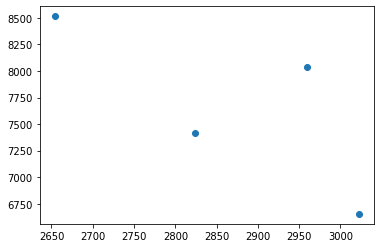

In [38]:
plt.scatter(df_comparison_mean["obs"], df_comparison_mean["sim"])

# comparaison avec résultats

8614.332632223746

# Comparaison avec SARRA-H

nan


/tmp/ipykernel_13040/3707673202.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


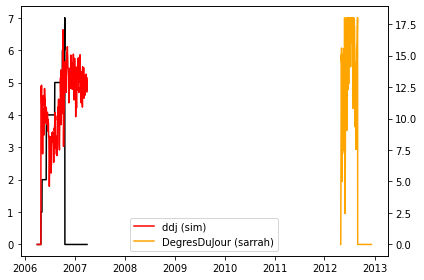

nan


/tmp/ipykernel_13040/3707673202.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


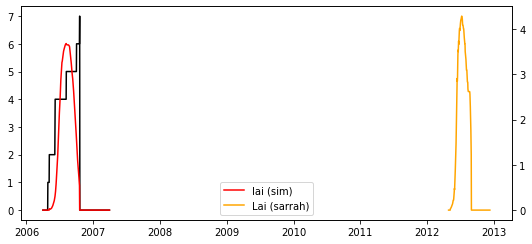

nan


/tmp/ipykernel_13040/3707673202.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


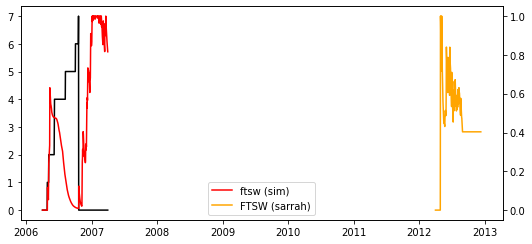

nan


/tmp/ipykernel_13040/3707673202.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


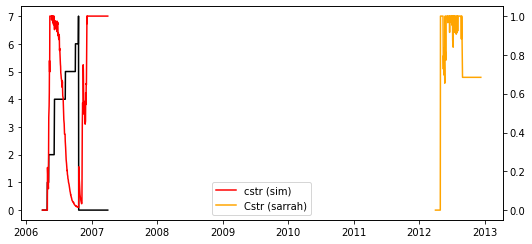

nan


/tmp/ipykernel_13040/3707673202.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


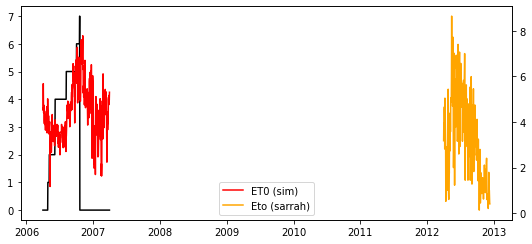

nan


/tmp/ipykernel_13040/3707673202.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


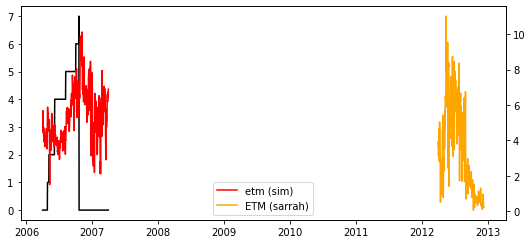

nan


/tmp/ipykernel_13040/3707673202.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


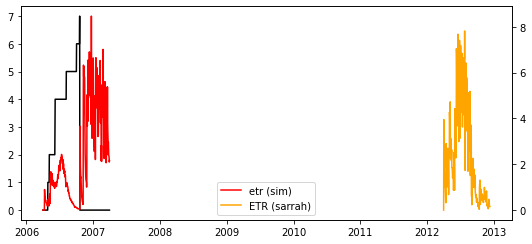

nan


/tmp/ipykernel_13040/3707673202.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


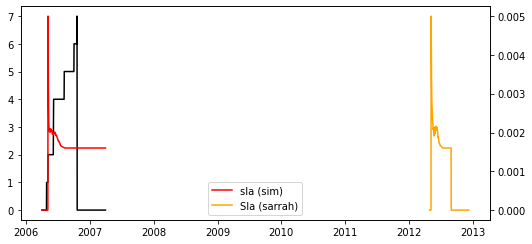

nan


/tmp/ipykernel_13040/3707673202.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


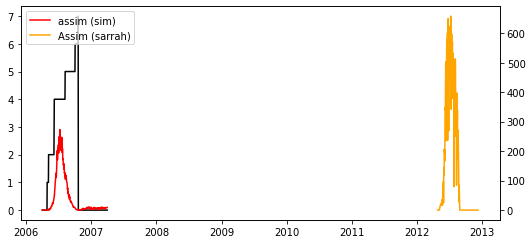

nan


/tmp/ipykernel_13040/3707673202.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


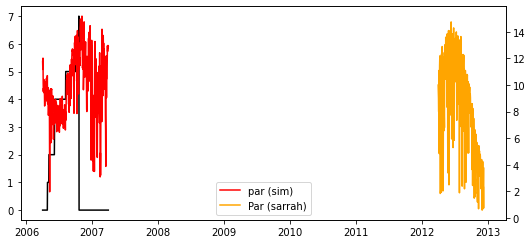

nan


/tmp/ipykernel_13040/3707673202.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


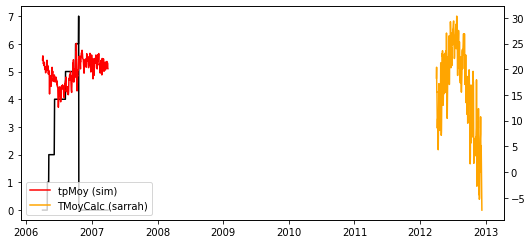

nan


/tmp/ipykernel_13040/3707673202.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


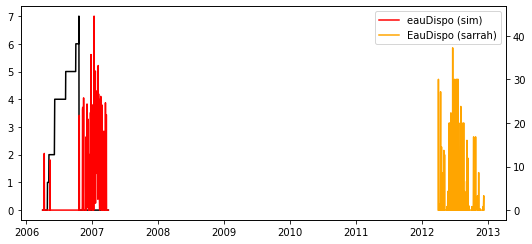

nan


/tmp/ipykernel_13040/3707673202.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


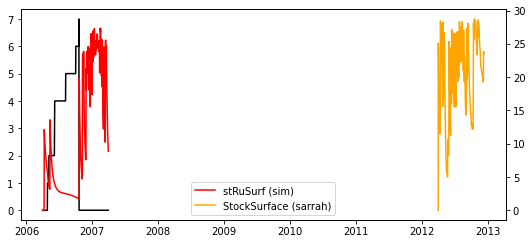

nan


/tmp/ipykernel_13040/3707673202.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


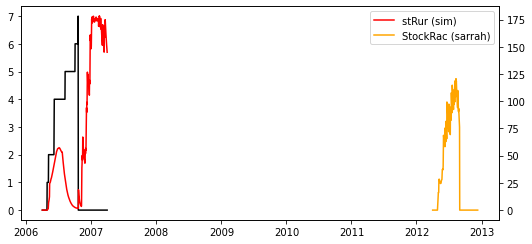

nan


/tmp/ipykernel_13040/3707673202.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


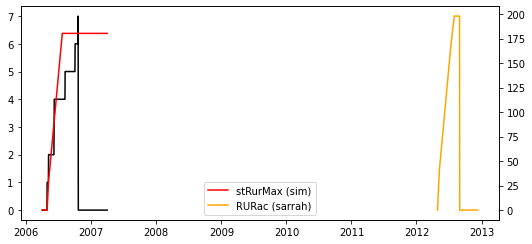

nan


/tmp/ipykernel_13040/3707673202.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


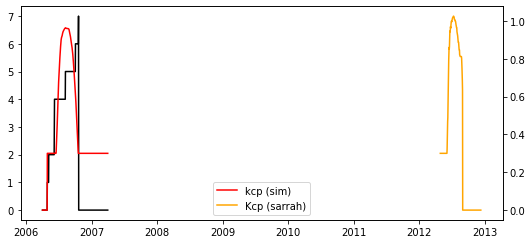

nan

/tmp/ipykernel_13040/3707673202.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


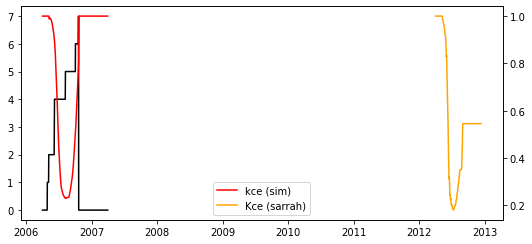

nan


/tmp/ipykernel_13040/3707673202.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


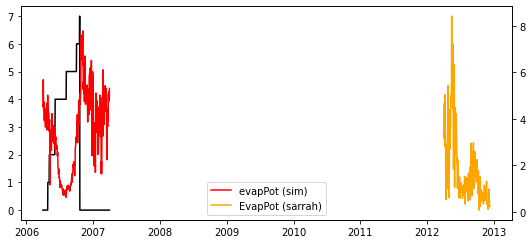

nan


/tmp/ipykernel_13040/3707673202.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


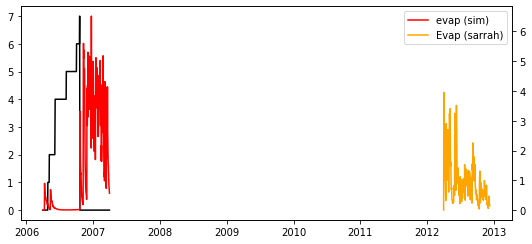

nan


/tmp/ipykernel_13040/3707673202.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


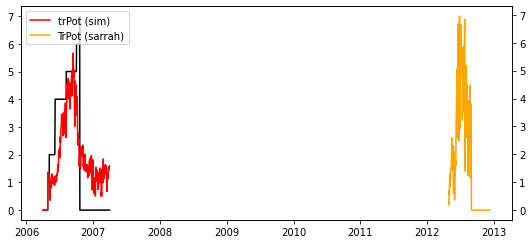

nan


/tmp/ipykernel_13040/3707673202.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


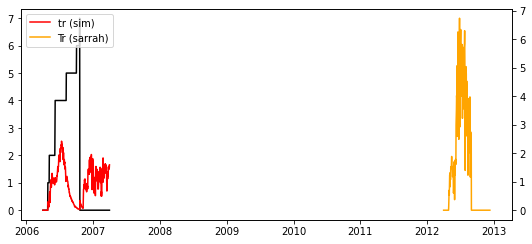

nan


/tmp/ipykernel_13040/3707673202.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


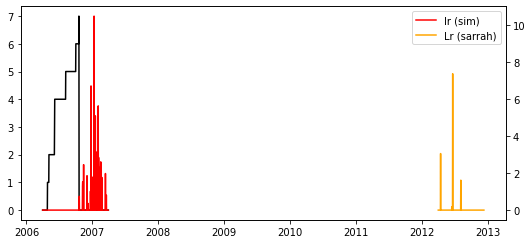

nan


/tmp/ipykernel_13040/3707673202.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


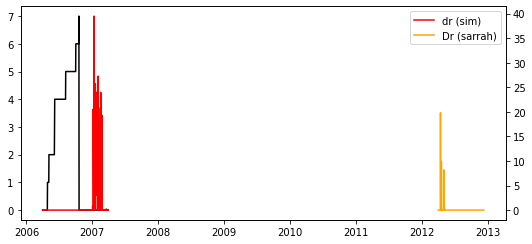

nan


/tmp/ipykernel_13040/3707673202.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


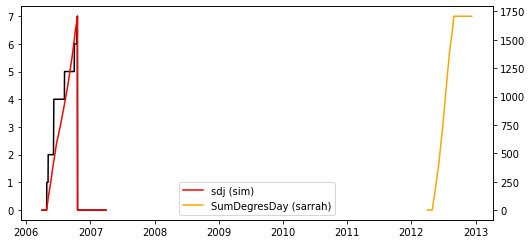

nan


/tmp/ipykernel_13040/3707673202.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


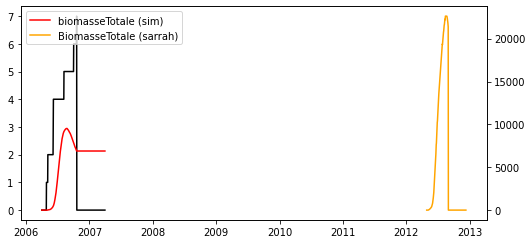

nan


/tmp/ipykernel_13040/3707673202.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


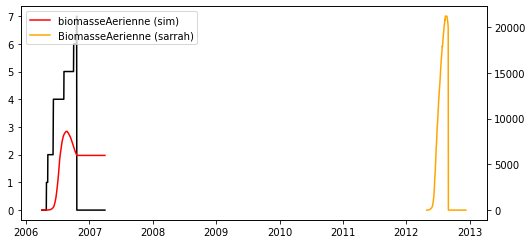

nan


/tmp/ipykernel_13040/3707673202.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


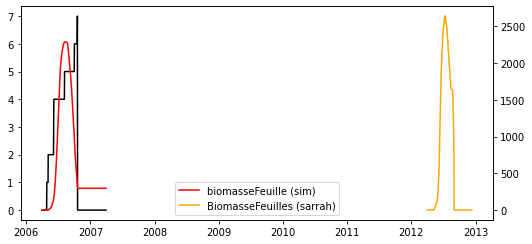

nan


/tmp/ipykernel_13040/3707673202.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


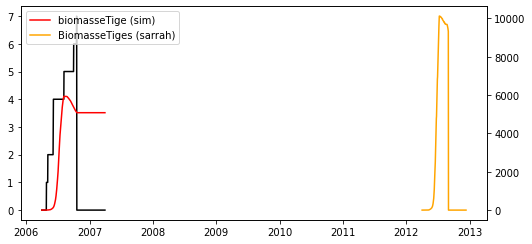

nan


/tmp/ipykernel_13040/3707673202.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


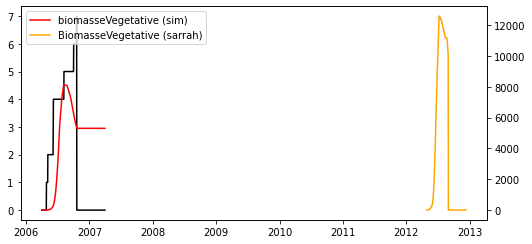

nan


/tmp/ipykernel_13040/3707673202.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


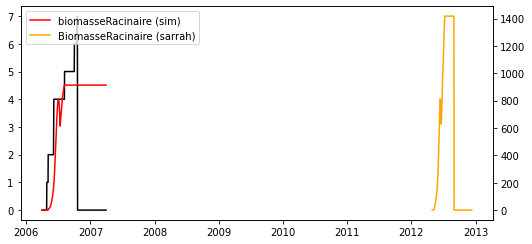

nan


/tmp/ipykernel_13040/3707673202.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


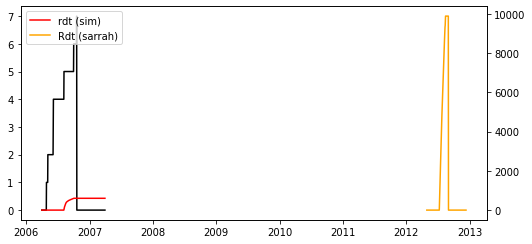

nan


/tmp/ipykernel_13040/3707673202.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


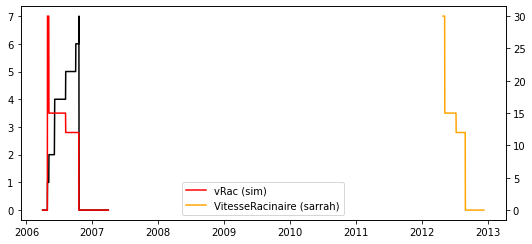

nan


/tmp/ipykernel_13040/3707673202.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


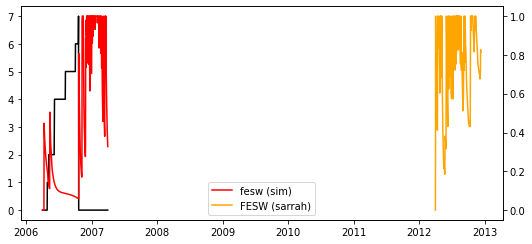

nan


/tmp/ipykernel_13040/3707673202.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


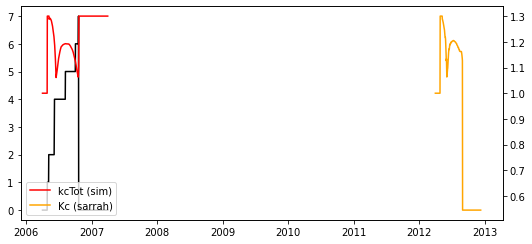

nan


/tmp/ipykernel_13040/3707673202.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


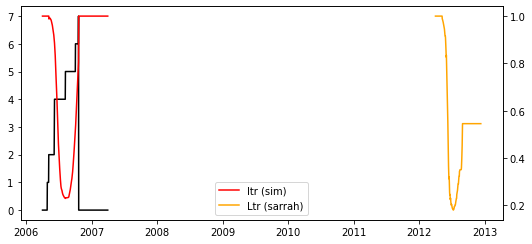

nan


/tmp/ipykernel_13040/3707673202.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


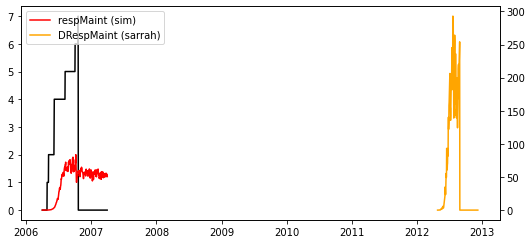

nan


/tmp/ipykernel_13040/3707673202.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


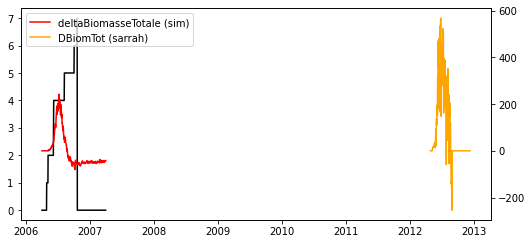

nan


/tmp/ipykernel_13040/3707673202.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


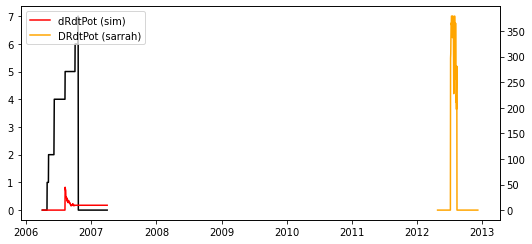

nan


/tmp/ipykernel_13040/3707673202.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


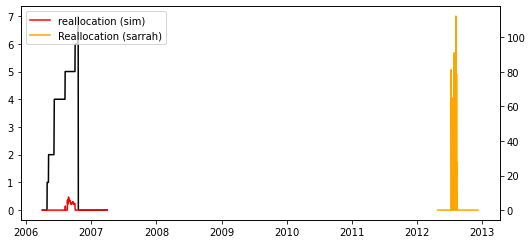

nan


/tmp/ipykernel_13040/3707673202.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


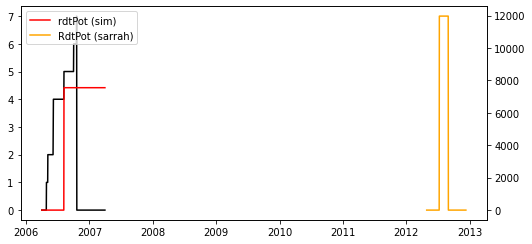

nan


/tmp/ipykernel_13040/3707673202.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


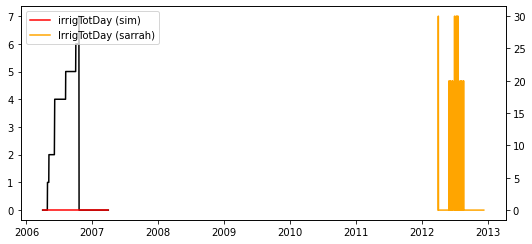

nan


/tmp/ipykernel_13040/3707673202.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


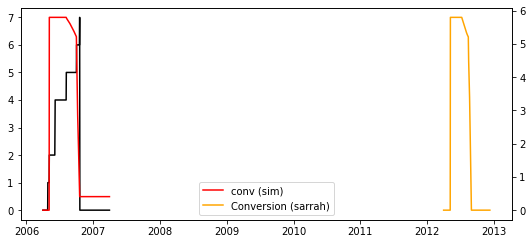

nan


/tmp/ipykernel_13040/3707673202.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


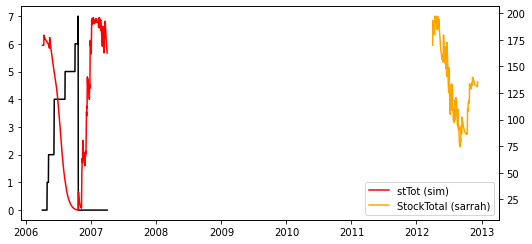

nan


/tmp/ipykernel_13040/3707673202.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


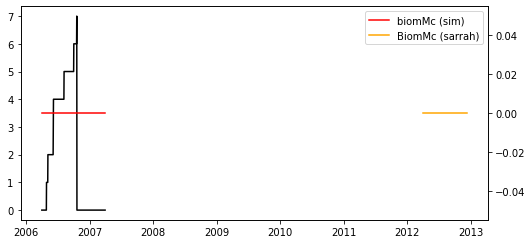

nan


/tmp/ipykernel_13040/3707673202.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))


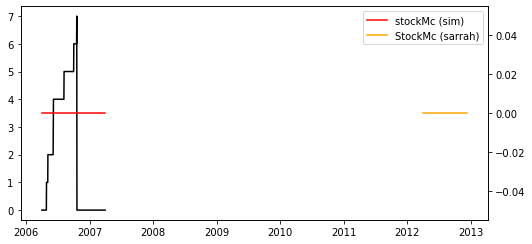

nan
nan
nan
nan
nan


/tmp/ipykernel_13040/3707673202.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))
/tmp/ipykernel_13040/3707673202.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))
/tmp/ipykernel_13040/3707673202.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))
/tmp/ipykernel_13040/3707673202.py:13: FutureWarning: The frame.append method is depreca

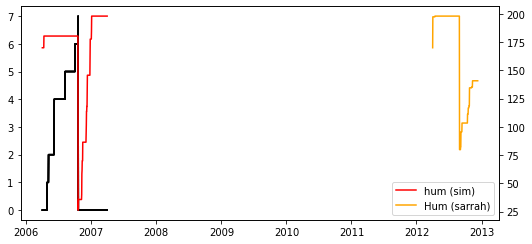

In [27]:
df_gt = pd.read_csv(os.path.join('../../data/sim/',file_df_sim), sep="\t", decimal=",")
df_gt["Jour"] = df_gt.apply(lambda x: datetime.datetime.strptime(x["Jour"], "%d/%m/%Y").date(), axis=1)

diff = pd.DataFrame()
var_correspondance = get_var_correspondance()

for var in var_correspondance :
    try:
        # print(var,var_correspondance[var])
        
        date, meandiff = compute_earliest_diff(var, var_correspondance[var], data, df_weather, df_gt)
        print(date)
        diff = diff.append(pd.DataFrame({"var":var,"var2":var_correspondance[var],"earliest_diff":date, "meandiff":meandiff}, index=[0]))
        try:
            graph_comparison(var, var_correspondance[var], data, df_weather, df_gt)
        except:
            pass
    except:
        print(var,'failed')
        pass

In [9]:
diff.sort_values(by="earliest_diff")

,var,var2,earliest_diff,meandiff
0,DRdtPot,dRdtPot,2012-08-15,146.232875
0,BiomasseTotale,biomasseTotale,2012-08-30,9618.057593
0,Lai,lai,2012-08-30,0.005408
0,Conversion,conv,2012-08-30,0.194743
0,BiomasseFeuilles,biomasseFeuille,2012-08-30,312.849145
0,DBiomTot,deltaBiomasseTotale,2012-08-30,36.699053
0,BiomasseTiges,biomasseTige,2012-08-30,3745.256065
0,Assim,assim,2012-08-30,2.796452
0,BiomasseAerienne,biomasseAerienne,2012-08-30,8981.055160
0,BiomasseVegetative,biomasseVegetative,2012-08-30,4477.218309
